In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from scipy.stats import skew
from math import sqrt
from sklearn import linear_model
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 300)

%matplotlib inline
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 300)

In [6]:
df_test = pd.read_csv('C:\\Users\\STEVEN\\Documents\\Thinkful\\Files\\Housing\\housing_test.csv', index_col='Id')
df_train = pd.read_csv('C:\\Users\\STEVEN\\Documents\\Thinkful\\Files\\Housing\\train.csv', index_col='Id')

In [8]:
y_train = df_train.SalePrice
df_train = df_train.drop(columns='SalePrice')

In [9]:
from sklearn.preprocessing import Imputer

# Replace NaN with corresponding Neighborhood Median
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
df_test["LotFrontage"] = df_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
    
# Replace NaN with Feature Median 
numerical_features = df_train.select_dtypes(include='number').columns
my_imputer = Imputer()
df_train[numerical_features] = my_imputer.fit_transform(df_train[numerical_features])
df_test[numerical_features] = my_imputer.transform(df_test[numerical_features])

In [10]:
idx_split = df_train.shape[0]
df_train = df_train.append(df_test)

In [11]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    df_train[col]=df_train[col].astype(str)
    
non_ordinal_features = ['LandSlope','Utilities','MSZoning', 'Street','Alley','LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd','MasVnrType','Foundation', 'BsmtExposure','BsmtFinType1','BsmtFinType2', 'Heating', 'CentralAir', 'Electrical','Functional', 'GarageType','GarageFinish','PavedDrive', 'Fence','MiscFeature','SaleType','SaleCondition', "MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
ordinal_features = df_train.select_dtypes(include='object').columns.drop(non_ordinal_features)

In [12]:
dummies = pd.get_dummies(df_train.loc[:,non_ordinal_features], drop_first=True)
df_train = pd.concat([df_train,dummies], axis=1)
df_train = df_train.drop(non_ordinal_features,axis=1)

In [13]:
X = df_train.loc[:idx_split, :]
X_test = df_train.loc[idx_split+1:, :]

In [26]:
X = X.assign(SalePrice=y_train)

In [16]:
corr_matrix = X.drop(dummies,axis=1).corr()

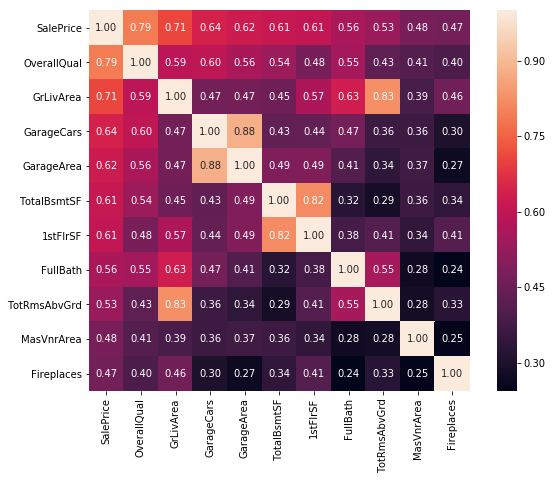

In [17]:
_, ax = plt.subplots(ncols=1, figsize=(10,7))
cols = corr_matrix.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [22]:
X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
X["TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
X["GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]


X_test["TotalHouse"] = X_test["TotalBsmtSF"] + X_test["1stFlrSF"] + X_test["2ndFlrSF"]   
X_test["TotalHouse_OverallQual"] = X_test["TotalHouse"] * X_test["OverallQual"]
X_test["GrLivArea_OverallQual"] = X_test["GrLivArea"] * X_test["OverallQual"]


In [23]:
print(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
X = X.drop(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
y_train = y_train.drop([524, 1299])

Int64Index([524, 1299], dtype='int64', name='Id')


In [27]:
D = X['SalePrice'].values.reshape(-1,1)
Z = X[['TotalHouse_OverallQual'] + ['GrLivArea'] + ['OverallCond']+ ['LotArea']]

In [43]:
#Creating the OLS Regression: 
regr = linear_model.LinearRegression()
regr.fit(Z,D)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(Z, D))



Coefficients: 
 [ 9.23945881e+00 -6.03749270e+00  3.85372070e+03  6.47699077e-01]

Intercept: 
 11145.2308073366

R-squared:
0.853767375083972


In [31]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regr, Z, D, cv=5)
print(score)

[0.82890263 0.86492041 0.86003422 0.81741933 0.86670938]


In [33]:
from sklearn.model_selection import train_test_split

Z_train, Z_test, D_train, D_test = train_test_split(Z, D, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(Z_train, D_train).score(Z_test, D_test)))
print('Testing on Sample: ' + str(regr.fit(Z, D).score(Z, D)))

With 20% Holdout: 0.86777314984978
Testing on Sample: 0.853767375083972


In [41]:
#Using KNN
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)

knn.fit(Z, D)

Z_train, Z_test, D_train, D_test = train_test_split(Z, D, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(knn.fit(Z_train, D_train).score(Z_test, D_test)))
print('Testing on Sample: ' + str(knn.fit(Z, D).score(Z, D)))

score = cross_val_score(knn, Z, D, cv=5)
print(score)

With 20% Holdout: 0.8268638765141912
Testing on Sample: 0.8626633312233655
[0.82549762 0.8536528  0.80690911 0.8120108  0.81721137]


They are both very similar using my models.  While testing on the sample it appears that KNN is better at predicting than the regr model.  However when testing on smaller values and using K-folds the regr works better than the knn model. A similarity is that they both have an accuracy in the mid 80s

I believe their may be some skewness that is adversely affecting the regression model.  Due to possibly very high houses that are affecting the linear regression while the high house prices are able to be handled differently in the KNN model.

Once the skewness is elimenated I would definetly prefer using linear regression to the KNN.  Due to it's better performance, overall. 